<a href="https://colab.research.google.com/github/johanv26/Analitica/blob/main/videogames_full_GlobalSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#descargar datos video_games
!pip install wget
import wget
import pandas as pd
#datos video juelgos-2016
#csv file id#
FILE_ID='1kMvhv1VpUpGmyyDZneZ7DaIpXZx9826Z'
url='https://drive.google.com/uc?export=download&id='+FILE_ID
#datos Colombia
import os.path as path
csv_file='Video_Games_Sales_as_at_22_Dec_2016.csv'
if not path.exists(csv_file):
  wget.download(url,csv_file)

gamesdf = pd.read_csv(csv_file)
gamesdf.head(20)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,594.0,Nintendo,E
9,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Paso 2: Particion entrenamiento y validacion
#Tamanio Xtrain 70%. Tamanio Xtest=30%
from sklearn.model_selection import train_test_split
import warnings
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")
df_train, df_test =train_test_split(gamesdf,test_size=0.3)
col_sal= 'Year_of_Release'
ytrain=df_train[col_sal]
ytest=df_test[col_sal]
df_train.drop(columns=col_sal,inplace=True)
df_test.drop(columns=col_sal,inplace=True)
ytrain

5009     1996.0
11339       NaN
11143    2011.0
16427    2016.0
176      2012.0
          ...  
6089     1997.0
6808     2008.0
10037    2004.0
11894    2011.0
2247     2015.0
Name: Year_of_Release, Length: 11703, dtype: float64

In [ ]:
#Completao de datos por moda de la salida Global sales
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='most_frequent')
ytrain=imputer.fit_transform(pd.DataFrame(ytrain))
ytrain=ytrain.reshape(-1)

ytest=imputer.transform(pd.DataFrame(ytest))
ytest=ytest.reshape(-1)

print(ytrain.shape,ytest.shape)

(11703,) (5016,)


In [ ]:
import numpy as np

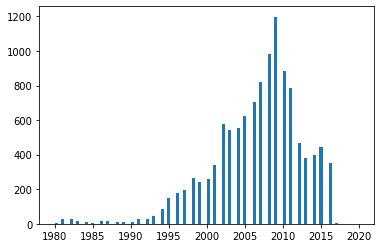

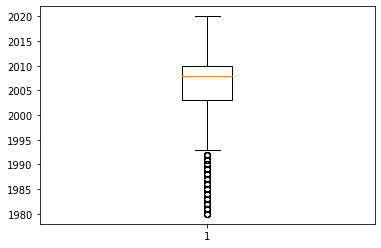

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ytrain,bins=100)
plt.show()

#diagrama de caja

#caja->
plt.boxplot(ytrain)
plt.show()

In [ ]:
#definir columnas 
col_scores = ['User_Score','Critic_Score','Critic_Count','User_Count']
# Strange values tbd

cat = ['Name','Platform','Genre','Publisher','Developer','Rating']
items = [] 
for i in cat:
    items += [list(gamesdf[i].value_counts().index)]
cat_names = dict(zip(cat, items))



```
# Tiene formato de código
```

 #Crear clase propia de preproceso para video juegos

In [ ]:
#%% dummy transformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
class dummy_games(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self,col_scores, cat_usr):#constructor clase
        
        self.col_stats = col_scores#lista atributos tipo score
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent")#crear imputador tipo modo
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        #print(a)
        self.imputer_num.fit(Xi[self.a])# ajustar imputador
        
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar  sobre datos imputador
        
        #codificar
        #only User_Score is cnahge the tbd most frequetn for mean.
        frec_val=gamesdf['User_Score'].value_counts()
        mean=np.mean(frec_val.index[1:].astype('float64')) 
        Xi['User_Score'].replace(regex=["tbd"], value=mean,inplace=True)      
        Xi['User_Score'] = Xi['User_Score'].astype('float64');
        

        
        
        
        cat = []#codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        

        
        return self    

    def transform(self, X, *_):
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])

              
        frec_val=gamesdf['User_Score'].value_counts()
        mean=np.mean(frec_val.index[1:].astype('float64')) 
        Xi['User_Score'].replace(regex=["tbd"], value=mean,inplace=True)      
        Xi['User_Score'] = Xi['User_Score'].astype('float64');
          
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        
        #Fase de transformacion
        #
        
        return Xi
    
    def fit_transform(self,X,*_):
        self.fit(X)
        return self.transform(X)
#%%

In [ ]:
dummy=dummy_games(col_scores=col_scores,cat_usr=cat_names)
dftrain_pre=dummy.fit_transform(df_train)
dftrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11703 entries, 5009 to 2247
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          11703 non-null  float64
 1   Platform      11703 non-null  float64
 2   Genre         11703 non-null  float64
 3   Publisher     11703 non-null  float64
 4   NA_Sales      11703 non-null  float64
 5   EU_Sales      11703 non-null  float64
 6   JP_Sales      11703 non-null  float64
 7   Other_Sales   11703 non-null  float64
 8   Global_Sales  11703 non-null  float64
 9   Critic_Score  11703 non-null  float64
 10  Critic_Count  11703 non-null  float64
 11  User_Score    11703 non-null  float64
 12  User_Count    11703 non-null  float64
 13  Developer     11703 non-null  float64
 14  Rating        11703 non-null  float64
dtypes: float64(15)
memory usage: 1.4 MB


# Predicción variable de interés desde datos preprocesados

In [ ]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
sca = StandardScaler()
dftrain_pre_z = sca.fit_transform(dftrain_pre)

In [ ]:
dftrain_pre_z

array([[-0.40560691,  0.04469935, -1.1516564 , ..., -0.18357   ,
        -0.54650801, -0.63293221],
       [-0.35593966, -0.92439375,  1.24818955, ..., -0.18357   ,
        -0.52828737, -0.63293221],
       [-0.9022794 , -0.53675651, -0.55169491, ..., -0.18357   ,
        -0.52828737,  2.46977889],
       ...,
       [-0.52531056,  0.43233659,  0.04826658, ..., -0.18357   ,
         3.6533485 ,  0.40130483],
       [-0.88414249, -0.34293789,  0.64822807, ..., -0.18357   ,
        -0.54650801, -0.63293221],
       [-0.92599691,  1.40142969, -0.85167566, ...,  0.28249568,
        -0.40074292, -0.63293221]])

In [ ]:
dftrain_pre_z.var(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
dftrain_pre.var(axis=0)

Name            1.284508e+07
Platform        2.662233e+01
Genre           1.111349e+01
Publisher       5.928002e+03
NA_Sales        6.840003e-01
EU_Sales        2.582391e-01
JP_Sales        9.691093e-02
Other_Sales     4.039379e-02
Global_Sales    2.473329e+00
Critic_Score    9.517153e+01
Critic_Count    2.945463e+02
User_Score      2.147158e+00
User_Count      1.592828e+05
Developer       1.084458e+05
Rating          9.349684e-01
dtype: float64

In [ ]:
red = PCA()
zz = red.fit_transform(dftrain_pre_z)

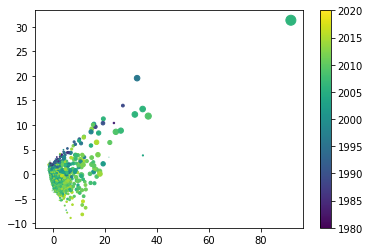

In [ ]:
plt.scatter(zz[:,0],zz[:,1],c=ytrain,s = 100*dftrain_pre['EU_Sales']/(dftrain_pre['EU_Sales'].max()))
plt.colorbar()
plt.show()

In [ ]:
# proceso con test
dftest_pre = dummy.transform(df_test)

In [ ]:
dftest_pre['EU_Sales']

12800    0.00
15046    0.01
9092     0.00
2989     0.22
6650     0.10
         ... 
173      1.21
6461     0.10
5084     0.14
11312    0.00
16129    0.00
Name: EU_Sales, Length: 5016, dtype: float64

In [ ]:
dftest_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5016 entries, 12800 to 16129
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          5016 non-null   float64
 1   Platform      5016 non-null   float64
 2   Genre         5016 non-null   float64
 3   Publisher     5016 non-null   float64
 4   NA_Sales      5016 non-null   float64
 5   EU_Sales      5016 non-null   float64
 6   JP_Sales      5016 non-null   float64
 7   Other_Sales   5016 non-null   float64
 8   Global_Sales  5016 non-null   float64
 9   Critic_Score  5016 non-null   float64
 10  Critic_Count  5016 non-null   float64
 11  User_Score    5016 non-null   float64
 12  User_Count    5016 non-null   float64
 13  Developer     5016 non-null   float64
 14  Rating        5016 non-null   float64
dtypes: float64(15)
memory usage: 627.0 KB


In [ ]:
#Xtest_pre_z = sca.transform(Xtest_pre) # standardizacion
#zztest = red.transform(Xtest_pre_z) # llevarlo a 2D con pca

zztest = red.transform(sca.transform(dummy.transform(df_test))) # una sola linea

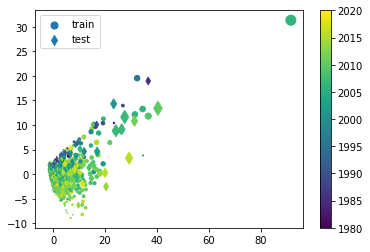

In [ ]:
plt.scatter(zz[:,0],zz[:,1],c=ytrain,s = 100*dftrain_pre['EU_Sales']/(dftrain_pre['EU_Sales'].max()),label='train')
plt.colorbar()
plt.scatter(zztest[:,0],zztest[:,1],c=ytest,s=100*dftest_pre['EU_Sales']/dftest_pre['EU_Sales'].max(),marker='d',label='test')
plt.legend()
plt.show()

In [ ]:
# definir modelos de predicción
from sklearn.linear_model import LinearRegression, ElasticNet

steps = [
         [('scaler', StandardScaler()), #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg', LinearRegression())],
         
         [('scaler',StandardScaler()),
          ('reg',ElasticNet())]
         
        # [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
        #  ('reg',  KernelRidge(kernel = 'rbf'))], #clasificador 
         ]        

#parametros a buscar por busqueda por grilla
parameters =[ 
             {'reg__fit_intercept':[True, False]             
             },
             {
              'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros n_neighbors debe ser siempre un int
              'reg__l1_ratio':[0,0.25,0.5,0.75,1]
             }
              ]

label_model = ['Nor+RegLin','Nor+ElasticNet']

In [ ]:
parameters

[{'reg__fit_intercept': [True, False]},
 {'reg__alpha': [0, 0.001, 0.01, 0.1, 1, 10],
  'reg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}]

In [ ]:
import os
pathpre = 'datospre'

try:
  os.mkdir(pathpre)
except:
  print("Carpeta results ya existe")

Carpeta results ya existe


In [ ]:
#valildacion cruzada anidada
from joblib import dump, load
from sklearn.metrics import mean_absolute_error as msa 
Niter = 10 #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto/error
Nmod = len(steps) #numero de modelos a probar
best_estimators = Niter*[None]#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = Niter*[None]#mejor metodo por iteracion 


#############################
for j in range(Niter): #outter loop # SI TIENE MENOS DE 1000 DATOS BORRAR ESTE CICLO SOLO CV EN LINEA 16
      #print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_trainj, X_testj, y_trainj, y_testj = train_test_split(dftrain_pre,ytrain,test_size=0.3) # xtrain 60, xtest 26
      list_est = [] #lista lazo interno para guardar mejor estimador por modelo para iteracion j
      list_hyper = [] #lista lazo interno para guardar mejores hyperparametros por modelo para iteracion j
      for r in range(Nmod): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r],memory=pathpre), parameters[r],cv=5,verbose=5,scoring='neg_mean_absolute_error',n_jobs=-1) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          #generar mejor modelo
          grid_search.fit(X_trainj,y_trainj)
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_testj)
          #guardar mejor modelo
          list_est.append(grid_search.best_estimator_)
          list_hyper.append(grid_search.best_params_)
          #guardar acierto
          msev[j,r] = msa(y_testj,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r+1,len(steps)))
          print('best hyper', grid_search.best_params_)
          print('msa:',msev[j,r])
          
      best_estimators[j] = list_est #guardar mejores modelos 
      best_hyperpar[j] = list_hyper #mejores hyperparametros
          
          
      savedata = {
          'acc':msev,
          'best_models':best_estimators,
          'best_parameters':best_hyperpar,
            } 
      dump(savedata,'videogames.joblib')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 1/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.011455554847524
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 1/10-Modelo 2/2
best hyper {'reg__alpha': 0.01, 'reg__l1_ratio': 0.5}
msa: 4.012725981438147
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 2/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.120048046121391
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 2/10-Modelo 2/2
best hyper {'reg__alpha': 0, 'reg__l1_ratio': 0}
msa: 4.119880181108407
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 3/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.0580593613251255
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 3/10-Modelo 2/2
best hyper {'reg__alpha': 0, 'reg__l1_ratio': 0}
msa: 4.057906966810335
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 4/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.039188287549976
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 4/10-Modelo 2/2
best hyper {'reg__alpha': 0, 'reg__l1_ratio': 0}
msa: 4.03854936427749
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 5/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.099079033387267
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 5/10-Modelo 2/2
best hyper {'reg__alpha': 0, 'reg__l1_ratio': 0}
msa: 4.099052681517665
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 6/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.069386180102924
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 6/10-Modelo 2/2
best hyper {'reg__alpha': 0, 'reg__l1_ratio': 0}
msa: 4.068440434125986
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 7/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.048851591100405
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 7/10-Modelo 2/2
best hyper {'reg__alpha': 0.01, 'reg__l1_ratio': 1}
msa: 4.048270903172693
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 8/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.080891929371928
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 8/10-Modelo 2/2
best hyper {'reg__alpha': 0, 'reg__l1_ratio': 0}
msa: 4.080204228900644
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 9/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.095596525389448
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 9/10-Modelo 2/2
best hyper {'reg__alpha': 0, 'reg__l1_ratio': 0}
msa: 4.0947884060001725
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


it 10/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 4.078275872400066
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s


it 10/10-Modelo 2/2
best hyper {'reg__alpha': 0.01, 'reg__l1_ratio': 1}
msa: 4.0787144163712


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.9s finished


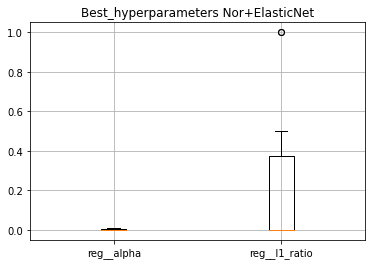

Modes=  [0. 0.]


In [ ]:
from scipy.stats import mode
from datetime import date

r = 1 #hyperparameters model 1
nh = len(best_hyperpar[0][r])
hyperpar_r = np.zeros((Niter,nh)) 
for i in range(Niter):
  for j in range(nh):
    hyperpar_r[i,j] = best_hyperpar[i][r].get(list(best_hyperpar[i][r].keys())[j])
    
    
#revisar numero entero para realizar casting
aa = list(best_hyperpar[0][r].keys())
c = -1
for i in range(len(aa)):
    if aa[i].find('n_neighbors') > -1:
      c = i

plt.boxplot(hyperpar_r)
plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperpar[0][r].keys()))
plt.title('Best_hyperparameters '+label_model[r])
plt.grid()
plt.show()

mode_hyper = mode(hyperpar_r,axis=0)[0][0]
print("Modes= ", mode_hyper)

# Modelo definitivo

Con los mejores hiperparámetros entreno sobre Xtrain completo el modelo final

In [ ]:
r = 1 #camino elastic net
steps_final = [('scaler',StandardScaler()),
               ('reg',ElasticNet(alpha=0.0,l1_ratio=0))]  
         
modelo_final = Pipeline(steps_final)
modelo_final.fit(dftrain_pre,ytrain)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True,
                            l1_ratio=0, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

# Caso real evaluación datos nuevos

In [ ]:
ytest_e = modelo_final.predict(dummy.transform(df_test)) #simular casos nuevos

In [ ]:
print('MAE_test=', msa(ytest,ytest_e))

MAE_test= 3.9567832730288717


In [ ]:
pathpre = 'resultados'

try:
  os.mkdir(pathpre)
except:
  print("Carpeta results ya existe")

Carpeta results ya existe


In [ ]:
import shutil
from joblib import dump, load
from datetime import date, datetime
from google.colab import files

modelo_final = {'modelo':modelo_final,
          'pasos':label_model[1],
          'mae_test':msa(ytest,ytest_e),
            } 

dump(modelo_final,'resultados/modelo_final.joblib')
namefile = str(datetime.now().strftime("%Y_%m_%d_%H_%M_%d"))+'__modelo'
shutil.make_archive(namefile, 'zip', 'resultados')
files.download(namefile+'.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>